In [ ]:
import os
import random
import shutil

base_path = "/content/drive/MyDrive/cars_tanks"

train_dir = os.path.join(base_path, "train")
val_dir = os.path.join(base_path, "val")

classes = ["tanks", "cars"]
num_to_move = 100

for cls in classes:
    src = os.path.join(train_dir, cls)
    dst = os.path.join(val_dir, cls)

    os.makedirs(dst, exist_ok=True)

    imgs = [f for f in os.listdir(src) if f.lower().endswith(".jpg")]
    selected = random.sample(imgs, num_to_move)

    for img in selected:
        shutil.move(os.path.join(src, img), os.path.join(dst, img))

print("Done.")

Done.


In [1]:
import tensorflow as tf
from tensorflow.keras import layers



In [2]:
import tensorflow as tf
from dataclasses import dataclass

math_ops = tf.math
PI = tf.cast(math_ops.angle(tf.constant(-1, dtype=tf.complex64)), tf.float32)


class Canny:
    def __init__(self, sigma: float = 0.8, threshold_min: int = 50, threshold_max: int = 80,
                 tracking_con: int = 5, tracking_iterations: int = 5):
        self.kernels = self.kernels(sigma, tracking_con)
        self.threshold = (threshold_min, threshold_max)
        self.tracking_iter = tracking_iterations

    def __call__(self, X):
        shape_ = X.get_shape()
        n_dim_ = len(shape_)
        d_type = X.dtype

        if n_dim_ < 2:
            raise ValueError(
                f'expected for 2/3/4D tensor but got {n_dim_}D'
            )

        X = tf.reshape(X, shape=(1, shape_[0], shape_[1], 1), name='X') if n_dim_ == 2 else X
        if n_dim_ == 3:
            X = tf.expand_dims(X, axis=-1, name='X') if shape_[-1] > 3 else tf.expand_dims(X, axis=0, name='X')

        if X.shape[-1] != 3 and X.shape[-1] != 1:
            raise ValueError(
                f'expected feature dim with size of 3 for RGB image and size of 1 for gray scale image'
            )

        if shape_[-1] == 3:
            X = tf.image.rgb_to_grayscale(X, name='X')

        kernels_ = self.kernels
        with tf.name_scope('noise_reduction'):
            gaussian_kernel = next(kernels_).kernel
            Xg = tf.nn.convolution(X, gaussian_kernel, padding='SAME', name='Xg')

        with tf.name_scope('gradient'):
            sobel_kernel = next(kernels_).kernel
            Gxy = tf.nn.convolution(Xg, sobel_kernel, padding='SAME', name='Gxy')
            gx, gy = tf.split(Gxy, [1, 1], axis=-1)
            theta = ((math_ops.atan2(gx, gy, name='theta') * 180 / PI) + 90) % 180
            Gxy = math_ops.sqrt((gx ** 2) + (gy ** 2), name='Gxy')
            Gxy = tf.clip_by_value(Gxy, 0, 255.)

        with tf.name_scope('non_maximum_suppression'):
            angle_kernel = next(kernels_)
            angle_X = []
            low, high = angle_kernel.carry[0]
            tmp = math_ops.logical_or(math_ops.greater_equal(theta, low), math_ops.less_equal(theta, high))
            angle_X.append(tmp)

            for low, high in angle_kernel.carry[1:]:
                tmp = math_ops.logical_and(math_ops.greater_equal(theta, low), math_ops.less(theta, high))
                angle_X.append(tmp)

            angle_X = tf.cast(tf.concat(angle_X, -1), tf.float32) * Gxy

            max_pool_ang = tf.nn.dilation2d(
                kernels_.pad(angle_X, h=1, w=1, constant_values=0.0),
                angle_kernel.kernel, (1, 1, 1, 1), 'VALID', 'NHWC', (1, 1, 1, 1)
            )

        with tf.name_scope('double_thresholding'):
            threshold_min, threshold_max = self.threshold
            edge_ = tf.where(
                math_ops.logical_and(math_ops.equal(max_pool_ang, angle_X), max_pool_ang > threshold_min), Gxy, 0.0
            )
            edge_ = tf.expand_dims(tf.reduce_max(edge_, axis=-1), -1)
            edge_sure = tf.where(edge_ >= threshold_max, 1.0, 0.0, name='edge_sure')
            edge_week = tf.where(
                math_ops.logical_and(edge_ >= threshold_min, edge_ < threshold_max), 1.0, 0.0, name='edge_week'
            )

        with tf.name_scope('dilation_tracking'):
            hysteresis_kernel = next(kernels_).kernel

            def check(curr, cond):
                return cond

            def main_(curr, cond):
                prev = tf.identity(curr, name='prev_connected')
                dilation = tf.nn.dilation2d(
                    curr, hysteresis_kernel, (1, 1, 1, 1), 'SAME', 'NHWC', (1, 1, 1, 1)
                )
                curr = (dilation * edge_week) + edge_sure - 1
                return curr, math_ops.reduce_max(curr - prev) != 0

            edge, _ = tf.while_loop(check, main_, loop_vars=(edge_sure, True), maximum_iterations=self.tracking_iter)
            edge = tf.where(edge + edge_sure > 0, 1.0, 0)

        if d_type == 'uint8':
            edge = edge * 255.0

        edge = tf.cast(edge, dtype=d_type, name='edge')
        return edge

    class kernels:
        def __init__(self, sigma: float = 0.8, con: int = 5):
            self.items = []
            if sigma < 0.8: raise ValueError('minimum kernel size need to be size of 3 --> sigma > 0.8')
            self.sigma = sigma
            self.con = con
            self.build()

        def __repr__(self):
            return str(self.items)

        def __next__(self):
            tmp = self.items.pop()
            self.items.insert(0, tmp)
            return tmp

        def build(self):
            sigma = self.sigma
            kernel_size = int(((((sigma - 0.8) / 0.3) + 1) * 2) + 1)
            kernel_size = kernel_size + 1 if (kernel_size % 2) == 0 else kernel_size

            ax = tf.range(-kernel_size // 2 + 1.0, kernel_size // 2 + 1.0)
            xx, yy = tf.meshgrid(ax, ax)
            normal = 1 / (2.0 * PI * (sigma ** 2))
            kernel = tf.exp(-((xx ** 2) + (yy ** 2)) / (2.0 * (sigma ** 2))) * normal

            kernel = kernel / tf.reduce_sum(kernel)
            gaussian_kernel = tf.reshape(kernel, shape=(kernel_size, kernel_size, 1, 1), name='gaussian_kernel')

            sobel_kernel = tf.constant(
                [
                    [[[-1, -1]], [[0, -2]], [[1, -1]]],
                    [[[-2, 0]], [[0, 0]], [[2, 0]]],
                    [[[-1, 1]], [[0, 2]], [[1, 1]]]
                ], dtype=tf.float32, name='sobel_kernel'
            )

            ang_0_kernel = tf.constant(
                [
                    [[-float('inf')], [-float('inf')], [-float('inf')]],
                    [[0.0], [0.0], [0.0]],
                    [[-float('inf')], [-float('inf')], [-float('inf')]]
                ], dtype=tf.float32, name='ang_0_kernel'
            )
            ang_45_kernel = tf.constant(
                [
                    [[-float('inf')], [-float('inf')], [0.0]],
                    [[-float('inf')], [0.0], [-float('inf')]],
                    [[0.0], [-float('inf')], [-float('inf')]]
                ], dtype=tf.float32, name='ang_45_kernel'
            )
            ang_90_kernel = tf.constant(
                [
                    [[-float('inf')], [0.0], [-float('inf')]],
                    [[-float('inf')], [0.0], [-float('inf')]],
                    [[-float('inf')], [0.0], [-float('inf')]]
                ], dtype=tf.float32, name='ang_90_kernel'
            )
            ang_135_kernel = tf.constant(
                [
                    [[0.0], [-float('inf')], [-float('inf')]],
                    [[-float('inf')], [0.0], [-float('inf')]],
                    [[-float('inf')], [-float('inf')], [0.0]]
                ], dtype=tf.float32, name='ang_135_kernel'
            )
            ang_kernel = tf.concat([ang_0_kernel, ang_45_kernel, ang_90_kernel, ang_135_kernel], axis=-1)

            dilation_kernel = tf.ones(shape=(self.con, self.con, 1), dtype=tf.float32)

            self.items = [self.__Node('gaussian_kernel', gaussian_kernel, None),
                          self.__Node('sobel_kernel', sobel_kernel, None),
                          self.__Node('ang_kernel', ang_kernel,
                                      [[157.5, 22.5], [22.5, 67.5], [67.5, 112.5], [112.5, 157.5]]),
                          self.__Node('dilation_kernel', dilation_kernel, None)
                          ]
            self.items.reverse()

        @staticmethod
        def pad(X, b=None, h=None, w=None, d=None, **kwargs):
            assert len(X.get_shape()) == 4
            if not b and not h and not w and not d: return X
            paddings = []
            for arg in [b, h, w, d]:
                arg = arg if arg is not None else [0, 0]
                arg = [arg, arg] if issubclass(type(arg), int) else list(arg)
                paddings.append(arg)
            paddings = tf.constant(paddings, dtype=tf.int32)
            padded = tf.pad(X, paddings, **kwargs)
            return padded

        @dataclass(eq=False, order=False, frozen=True)
        class __Node:
            __slots__ = ('name', 'kernel', 'carry')
            name: str
            kernel: tf.Tensor
            carry: object

            def __repr__(self):
                return self.name

In [3]:
import tensorflow as tf
from dataclasses import dataclass


In [42]:
canny_detector = Canny(
    sigma=0.8,
    threshold_min=60,
    threshold_max=80,
    tracking_con=5,
    tracking_iterations=5
)

#######################################
# 2) Define a map function to apply   #
#    Canny on each batch of images    #
#######################################
def apply_canny_edges(image_batch, label_batch):
    """
    Applies the Canny edge detection to a batch of images.

    Arguments:
    - image_batch: A batch of images shaped (batch_size, height, width, channels).
    - label_batch: A batch of corresponding labels (if any).

    Returns:
    - A tuple of (processed_images, label_batch).
    """
    # Apply the Canny detector to the image batch
    processed_images = canny_detector(image_batch)

    # Preserve the label batch as-is
    return processed_images, label_batch


In [43]:
directory_train = "/content/drive/MyDrive/cars_tanks/train"
directory_val = "/content/drive/MyDrive/cars_tanks/val"
directory_test = "/content/drive/MyDrive/cars_tanks/test"

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory_train,
    batch_size=256,
    image_size=(128, 128),
    shuffle=True,
    color_mode='rgb',
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory_val,
    batch_size=256,
    image_size=(128, 128),
    shuffle=True,
    color_mode='rgb',
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory_test,
    batch_size=256,
    image_size=(128, 128),
    shuffle=True,
    color_mode='rgb',
)

Found 1103 files belonging to 2 classes.
Found 200 files belonging to 2 classes.
Found 200 files belonging to 2 classes.


In [44]:
train_ds_canny = train_ds.map(apply_canny_edges)
val_ds_canny   = val_ds.map(apply_canny_edges)
test_ds_canny  = test_ds.map(apply_canny_edges)


Canny-edged images shape: (256, 128, 128, 1)
Labels shape: (256,)


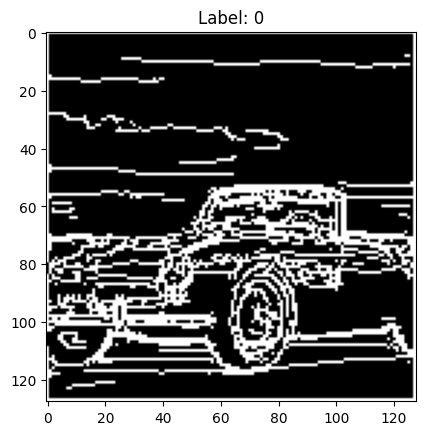

In [45]:
for canny_images, canny_labels in train_ds_canny.take(1):
    print("Canny-edged images shape:", canny_images.shape)
    print("Labels shape:", canny_labels.shape)
    # canny_images will already be in "edge" form as computed by the Canny class.
    # You could visualize them using matplotlib if desired:

    import matplotlib.pyplot as plt
    plt.imshow(canny_images[0].numpy().squeeze(), cmap='gray')
    plt.title(f"Label: {canny_labels[0].numpy()}")
    plt.show()



In [48]:
import tensorflow as tf

# Define a normalization function
def normalize_image(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # Scale pixel values to [0, 1]
    return image, label

# Apply normalization to train, validation, and test datasets
train_ds = train_ds.map(normalize_image)
val_ds = val_ds.map(normalize_image)
test_ds = test_ds.map(normalize_image)

# Optimize dataset performance (optional, but recommended)
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [49]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential()
model.add(layers.Input(shape=(128, 128, 3)))
model.add(layers.RandomRotation(factor=(-0.6, 0.6)))
model.add(layers.RandomZoom(height_factor=(0, 0.4)))
model.add(keras.layers.RandomFlip(mode="horizontal"))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.5))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.5))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
print(model.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_rotation_2               │ (None, 128, 128, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_2 (RandomZoom)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_2 (RandomFlip)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,433 (228.25 KB)

 Trainable params: 58,433 (228.25 KB)

 Non-trainable params: 0 (0.00 B)

None


In [50]:

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name="accuracy"),
    ],
)

In [14]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',      # metric to monitor
    patience=50,              # epochs with no improvement before stopping
    restore_best_weights=True,  # roll back to best model on validation loss
    mode='min',              # we want to minimize val_loss
    verbose=1
)



In [51]:
epochs = 500
history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        #callbacks=[early_stopping],
        verbose=1
    )

Epoch 1/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 24s 4s/step - accuracy: 0.5145 - loss: 0.6927 - val_accuracy: 0.5000 - val_loss: 0.6933
Epoch 2/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.5676 - loss: 0.6899 - val_accuracy: 0.5000 - val_loss: 0.6944
Epoch 3/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.5676 - loss: 0.6848 - val_accuracy: 0.5000 - val_loss: 0.6993
Epoch 4/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.5669 - loss: 0.6878 - val_accuracy: 0.5000 - val_loss: 0.7029
Epoch 5/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.5686 - loss: 0.6866 - val_accuracy: 0.5000 - val_loss: 0.7006
Epoch 6/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.5676 - loss: 0.6845 - val_accuracy: 0.5000 - val_loss: 0.6985
Epoch 7/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.5683 - loss: 0.6874 - val_accuracy: 0.5000 - val_loss: 0.6974
Epoch 8/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.5676 - loss: 0.6867 - val_accuracy: 0.5000 - val

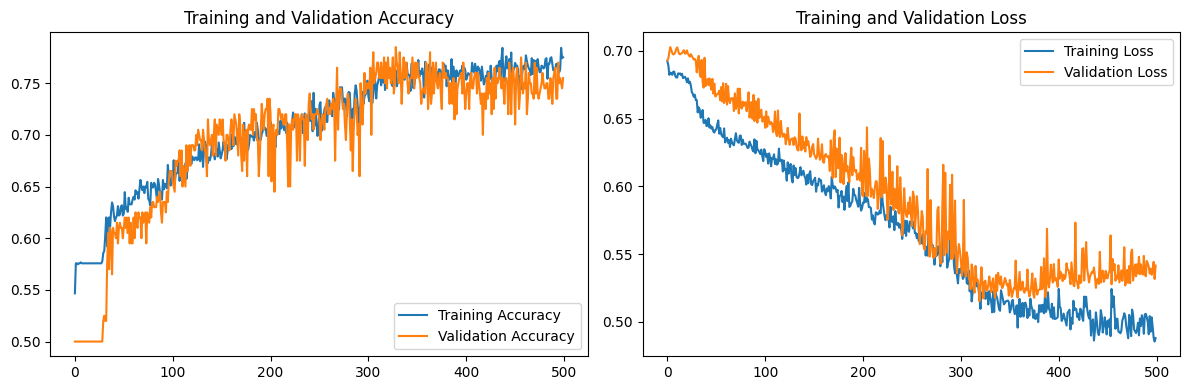

In [52]:
import matplotlib.pyplot as plt

# Extracting values from the training history
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(accuracy))

# Plotting Accuracy
plt.figure(figsize=(12, 4))

# Accuracy vs Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss vs Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# Display the plots
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7400 - loss: 0.4906
Test loss: 0.4906
Test accuracy: 0.7400
Confusion matrix (counts):
[[80 20]
 [22 78]]


<Figure size 500x400 with 0 Axes>

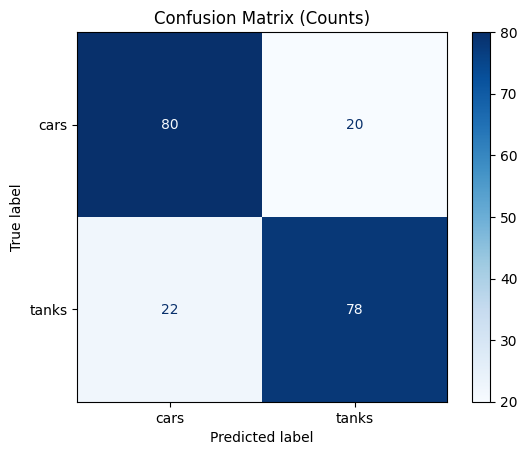

<Figure size 500x400 with 0 Axes>

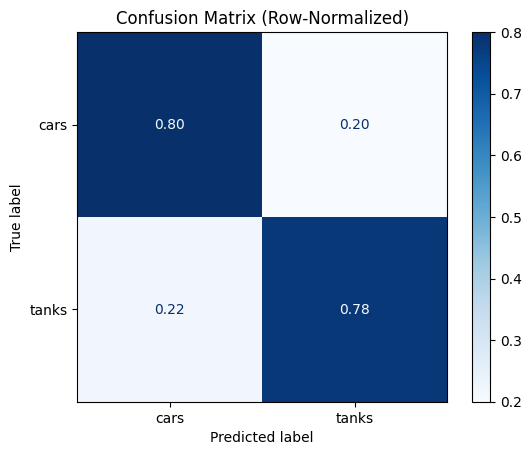

Normalized confusion matrix:
[[0.8  0.2 ]
 [0.22 0.78]]


In [59]:
# --- after training and plotting history ---

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 1) Evaluate on the test set
test_loss, test_acc = model.evaluate(test_ds, verbose=1)
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_acc:.4f}")

# 2) Collect predictions and true labels from test_ds
y_true = []
y_pred = []

for images, labels in test_ds:
    # Model outputs probabilities in [0,1]
    probs = model.predict(images, verbose=0).ravel()
    preds = (probs >= 0.4).astype(int)  # threshold at 0.5

    y_true.extend(labels.numpy())
    y_pred.extend(preds)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# 3) Compute confusion matrix (raw counts)
cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix (counts):")
print(cm)

# Class names in the order used by your datasets
class_names = ["cars", "tanks"]  # adjust to match train_ds.class_names

# 4) Plot raw confusion matrix
plt.figure(figsize=(5, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix (Counts)")
plt.show()

# 5) Compute and plot row‑normalized confusion matrix
cm_normalized = cm.astype("float") / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(5, 4))
disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_normalized,
                                   display_labels=class_names)
disp_norm.plot(cmap=plt.cm.Blues, values_format='.2f')
plt.title("Confusion Matrix (Row‑Normalized)")
plt.show()

print("Normalized confusion matrix:")
print(cm_normalized)

Model saved to: /content/drive/MyDrive/cars_tanks/cnn_model/cnn_cars_tanks.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7400 - loss: 0.4906
Test loss: 0.4906
Test accuracy: 0.7400
ROC AUC on test set: 0.8610


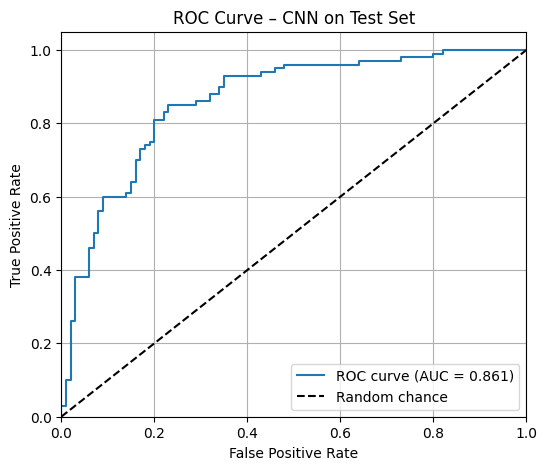

In [55]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# ========= 1) Save the trained model =========
# Choose a path/name for your saved model
save_dir = "/content/drive/MyDrive/cars_tanks/cnn_model"
os.makedirs(save_dir, exist_ok=True)

model_path = os.path.join(save_dir, "cnn_cars_tanks.h5")
model.save(model_path)
print(f"Model saved to: {model_path}")

# ========= 2) Evaluate on the test set =========
test_loss, test_acc = model.evaluate(test_ds, verbose=1)
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_acc:.4f}")

# ========= 3) Collect probabilities and labels for ROC/AUC =========
y_true = []
y_score = []   # probabilities (model outputs)

for images, labels in test_ds:
    # Get predicted probabilities for the positive class
    probs = model.predict(images, verbose=0).ravel()   # shape (batch,)
    y_score.extend(probs)
    y_true.extend(labels.numpy())

y_true = np.array(y_true)
y_score = np.array(y_score)

# ========= 4) Compute ROC curve and AUC =========
fpr, tpr, thresholds = roc_curve(y_true, y_score)  # assumes labels are 0/1
roc_auc = auc(fpr, tpr)

print(f"ROC AUC on test set: {roc_auc:.4f}")

# ========= 5) Plot ROC curve =========
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random chance")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – CNN on Test Set")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()